In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from math import ceil
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import phik
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

Note: This notebook does not include all the steps from the CRISP-DM methodology (mainly the non-code part, but also lacks some division of the CRISP-DM steps). Neverthless,as presented in the report, the CRISP-DM methodology was completly followed, including when working in this notebook.


## Data Understanding:

### Metadata


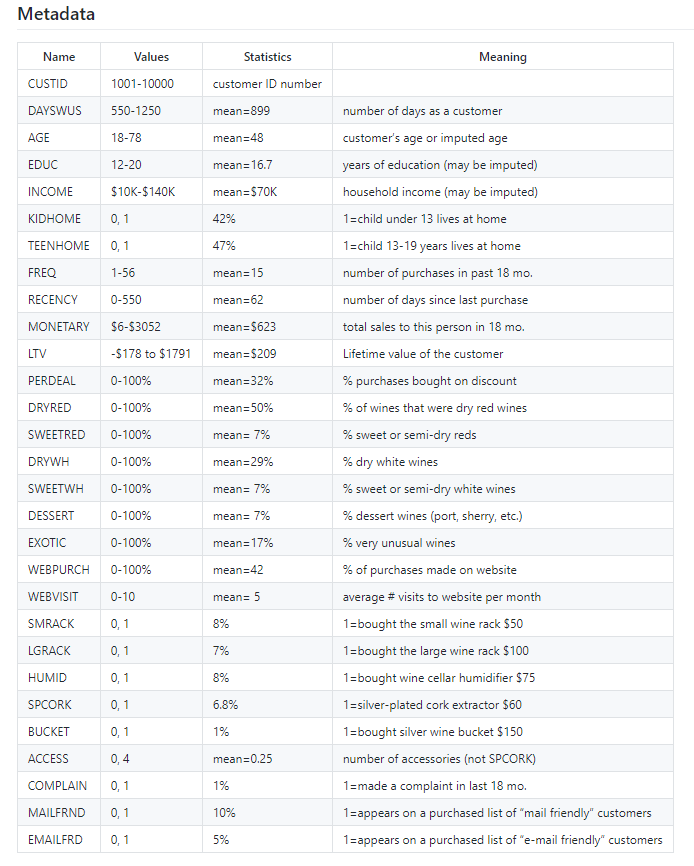

### Collect initial data

In [2]:
#Importing the dataset, droping a "random" column and the last row, as it represented the sum of the remaining, which doesn't have any usefulness for us.
#Then, we set the Customer ID as our index.

data = pd.read_excel("WonderfulWinesoftheWorld.xlsx")
data.drop("Rand", axis=1, inplace=True)
data.drop(data.tail(1).index, axis=0, inplace=True)
data.set_index(data["Custid"].astype(int), inplace=True)
data.drop("Custid", axis=1, inplace=True)

### Describe data

In [3]:
#checking the number of rows, number of variables and their types
data.info()
#number of variables : 28; number of customers: 10000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 5325 to 4914
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dayswus      10000 non-null  float64
 1   Age          10000 non-null  float64
 2   Edu          10000 non-null  float64
 3   Income       10000 non-null  float64
 4   Kidhome      10000 non-null  float64
 5   Teenhome     10000 non-null  float64
 6   Freq         10000 non-null  float64
 7   Recency      10000 non-null  float64
 8   Monetary     10000 non-null  float64
 9   LTV          10000 non-null  float64
 10  Perdeal      10000 non-null  float64
 11  Dryred       10000 non-null  float64
 12  Sweetred     10000 non-null  float64
 13  Drywh        10000 non-null  float64
 14  Sweetwh      10000 non-null  float64
 15  Dessert      10000 non-null  float64
 16  Exotic       10000 non-null  float64
 17  WebPurchase  10000 non-null  float64
 18  WebVisit     10000 non-null  float64
 19  SM

In [4]:
#Just a small look at the top rows of data before proceding to the data exploration (which also help to make the transiction to this next step).
data.head(10)

Dayswus   Age   Edu    Income  Kidhome  Teenhome  Freq  Recency  \
Custid                                                                    
5325      653.0  55.0  20.0   78473.0      0.0       0.0  20.0     18.0   
3956     1041.0  75.0  18.0  105087.0      0.0       0.0  36.0     33.0   
3681      666.0  18.0  12.0   27984.0      1.0       0.0   4.0     56.0   
2829     1049.0  42.0  16.0   61748.0      1.0       1.0   2.0     46.0   
8788      837.0  47.0  16.0   65789.0      0.0       1.0   2.0      3.0   
4356      916.0  54.0  20.0   76751.0      0.0       0.0  17.0     17.0   
7003      874.0  42.0  15.0   51644.0      1.0       1.0   2.0     19.0   
1815     1063.0  70.0  16.0   83942.0      0.0       0.0  29.0     20.0   
9139      853.0  26.0  17.0   33186.0      1.0       1.0   2.0     86.0   
6511      881.0  53.0  17.0   88538.0      0.0       1.0  17.0     12.0   

        Monetary    LTV  ...  WebVisit  SMRack  LGRack  Humid  Spcork  Bucket  \
Custid                   ...                                                    
5325       826.0  445.0  ...       5.0       0       0      0       0       0   
3956      1852.0  539.0  ...       4.0       0       0      0       1       0   
3681        39.0   -7.0  ...       8.0       0       0      0       0       0   
2829        37.0   -6.0  ...       7.0       0       0      0       0       0   
8788        36.0    4.0  ...       6.0       0       0      0       0       0   
4356       658.0  185.0  ...       5.0       0       0      0       0       0   
7003        33.0   -5.0  ...       5.0       1       0      0       0       0   
1815      1407.0  440.0  ...       2.0       0       0      0       0       0   
9139        21.0   -6.0  ...       8.0       0       0      0       0       0   
6511       651.0  195.0  ...       5.0       0       0      0       0       0   

        Access  Complain  Mailfriend  Emailfriend  
Custid                                             
5325         0         0           0            0  
3956         0         0           0            0  
3681         0         0           0            0  
2829         0         0           1            1  
8788         0         0           0            0  
4356         0         0           1            0  
7003         1         0           1            0  
1815         0         0           0            0  
9139         0         0           0            0  
6511         0         0           0            0  

[10 rows x 28 columns]

### Data Exploration

In [5]:
#Checking some statistical infromation regarding our metric features
data.drop(["Spcork","SMRack","LGRack","Humid","Bucket","Complain","Mailfriend","Emailfriend", "Kidhome", "Teenhome"], axis=1).describe().T

count        mean           std      min       25%      50%  \
Dayswus      10000.0    898.1020    202.492789    550.0    723.75    894.0   
Age          10000.0     47.9273     17.302721     18.0     33.00     48.0   
Edu          10000.0     16.7391      1.876375     12.0     15.00     17.0   
Income       10000.0  69904.3580  27612.233311  10000.0  47642.00  70012.0   
Freq         10000.0     14.6281     11.969073      1.0      4.00     12.0   
Recency      10000.0     62.4068     69.874255      0.0     26.00     52.0   
Monetary     10000.0    622.5552    647.135323      6.0     63.00    383.0   
LTV          10000.0    209.0712    291.986040   -178.0     -2.00     57.0   
Perdeal      10000.0     32.3972     27.897094      0.0      6.00     25.0   
Dryred       10000.0     50.3827     23.453815      1.0     32.00     51.0   
Sweetred     10000.0      7.0545      7.866544      0.0      2.00      4.0   
Drywh        10000.0     28.5213     12.583957      1.0     19.00     28.0   
Sweetwh      10000.0      7.0698      8.015083      0.0      2.00      4.0   
Dessert      10000.0      6.9474      7.879546      0.0      2.00      4.0   
Exotic       10000.0     16.5466     17.247672      0.0      4.00     10.0   
WebPurchase  10000.0     42.3762     18.522062      4.0     28.00     45.0   
WebVisit     10000.0      5.2166      2.330457      0.0      3.00      6.0   
Access       10000.0      0.2460      0.539178      0.0      0.00      0.0   

                  75%       max  
Dayswus       1074.00    1250.0  
Age             63.00      78.0  
Edu             18.00      20.0  
Income       92147.00  140628.0  
Freq            24.00      56.0  
Recency         78.25     549.0  
Monetary      1077.00    3052.0  
LTV            364.00    1791.0  
Perdeal         56.00      97.0  
Dryred          69.00      99.0  
Sweetred        10.00      75.0  
Drywh           37.00      74.0  
Sweetwh         10.00      62.0  
Dessert          9.00      77.0  
Exotic          23.00      96.0  
WebPurchase     57.00      88.0  
WebVisit         7.00      10.0  
Access           0.00       3.0

In [6]:
#Separating our variables into metric and binary, creating a list for each one
binaries = ["Spcork","SMRack","LGRack","Humid","Bucket","Complain","Mailfriend","Emailfriend", "Kidhome", "Teenhome"]
metric_features = data.columns.drop(binaries).to_list()

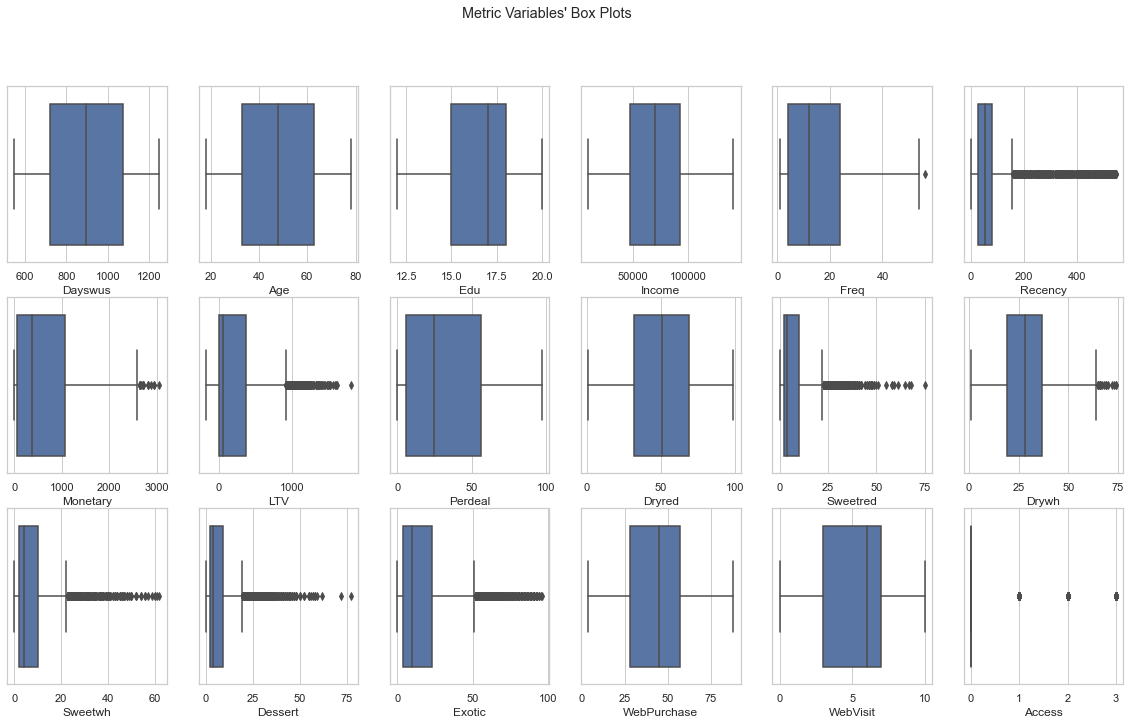

In [8]:
#Plotting boxplots for each metric feature, in order to analyse its distribution

#changing teh background
sns.set()
sns.set_style("whitegrid")

#defining the number of plots
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

#plotting each boxplot
for ax, features in zip(axes.flatten(), metric_features):
    sns.boxplot(x=data[features], ax=ax)
    
plt.suptitle("Metric Variables' Box Plots")
plt.show()

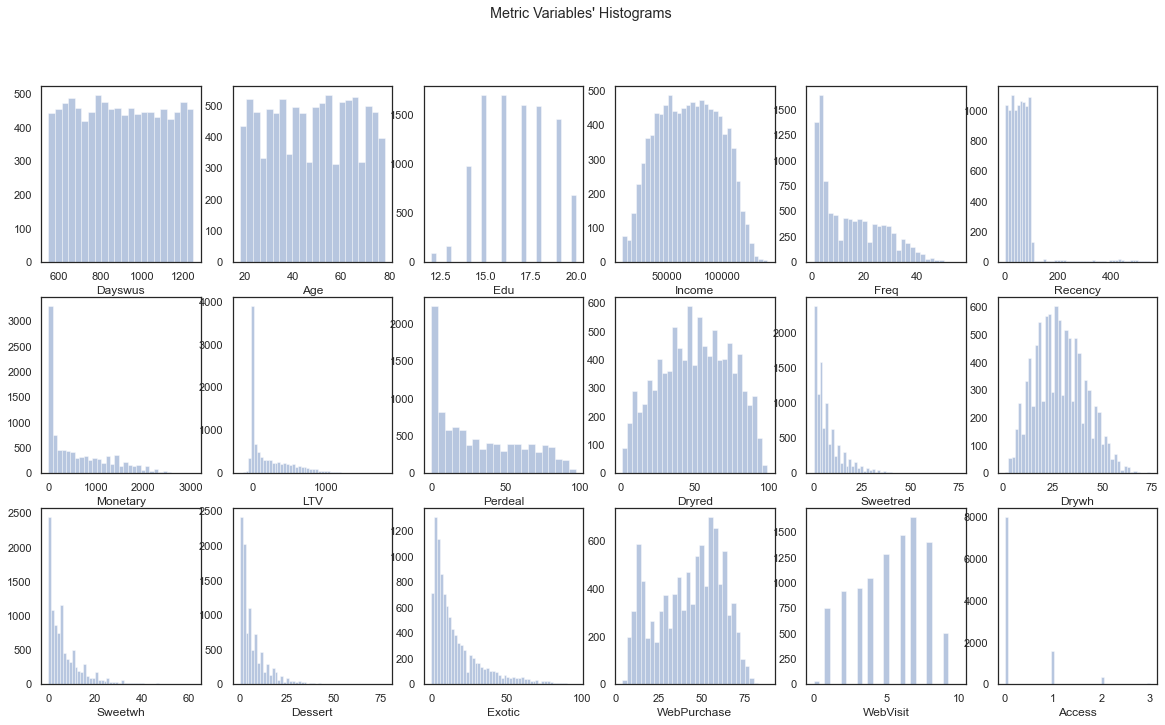

In [9]:
#Plotting histograms for each metric feature, in order to observe its distribution from another perspective

#setting the background
sns.set()
sns.set_style("white")

#defining the number of plots
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

#plotting each histogram
for ax, feature in zip(axes.flatten(), metric_features):
    sns.distplot(data[feature], kde=False, ax=ax)

plt.suptitle("Metric Variables' Histograms")
plt.show()

In [10]:
#Checking how many customers W.W.W. has whose Recency is higher than 100.
data[data["Recency"]>100].shape[0]

NumExpr defaulting to 8 threads.


447

In [1]:
# #setting the background
# sns.set_style("white")

# #plotting the pairplot for all metric features
# sns.pairplot(data=data[metric_features], diag_kind="hist")

# plt.show()

In [12]:
#Let us take advantage of the SOM visualization technique to get another perspective of our metric features. 

#Scaling our metric features, although not in the actual dataset, as this is not the proper place to do it according with the CRISP-DM, but is needed to apply a visualization technique with SOM
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(data[metric_features]), columns= metric_features, index= data.index)

#setting the "random_state"
np.random.seed(42)

#Creating the SOM model
sm = sompy.SOMFactory().build(
    x.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose=0, train_rough_len=100, train_finetune_len=100)

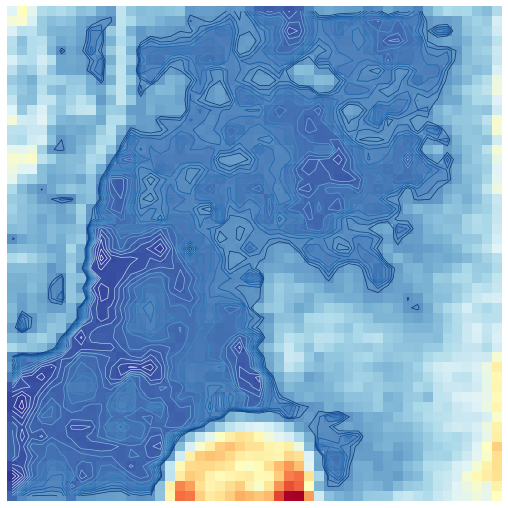

In [13]:
#Visualizing a U-Matrix for our dataset

u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)
#There seems to exist a strange pattern in our U-Matrix (red circular area).

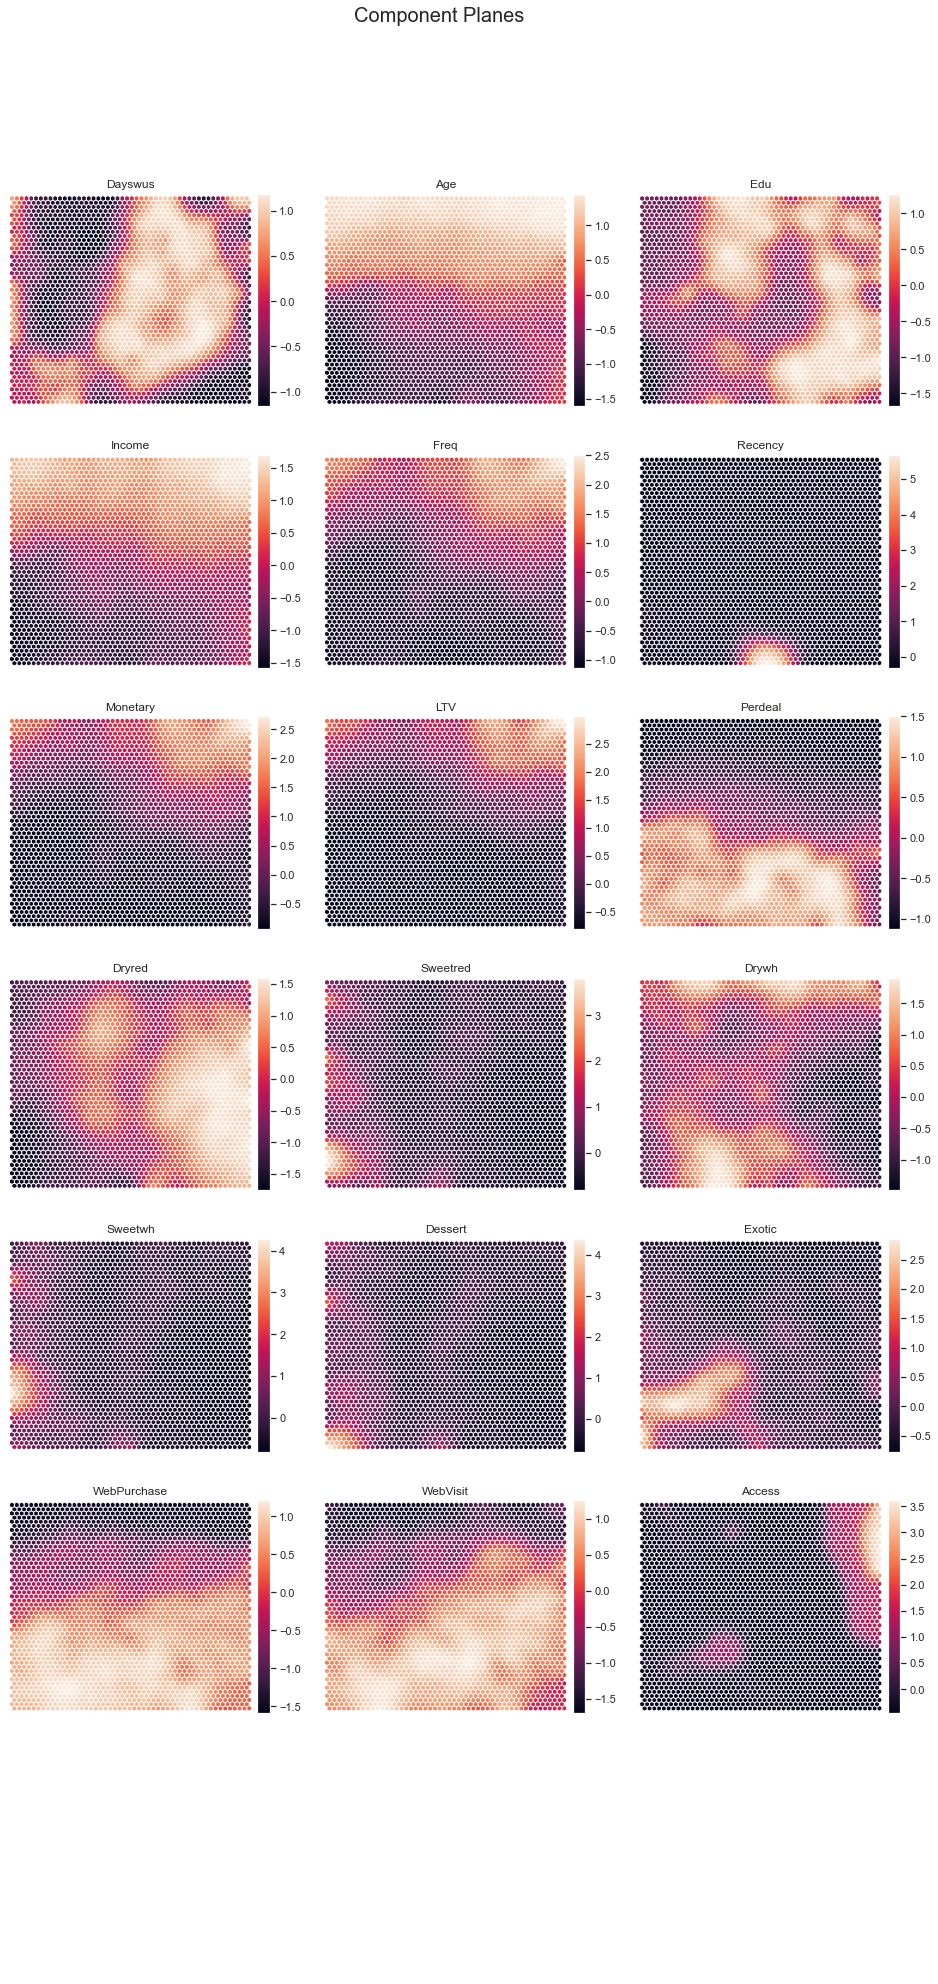

In [14]:
#Visualizing the Component planes for each metric feature

sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()


#In the component planes we can clearly attribute this behaviour to the Recency variable, that once more seem to be causing some issues.

In [15]:
#Now let us take a simple look at our categorical (already binarized) variables, and how frequent their values are.

#checking the distribution of 1's ("Yes") and 0's ("No") of our categorical features (already binarized)

df = pd.DataFrame()

for binary in binaries:
    df[binary] = (data[binary].value_counts())

df

#The majority of our variables seem to have a very unbalanced distribution with more "No" than "Yes" cases (converting its meaning from the dummy)

Spcork  SMRack  LGRack  Humid  Bucket  Complain  Mailfriend  Emailfriend  \
0    9318    9183    9304   9183    9870      9888        8981         9489   
1     682     817     696    817     130       112        1019          511   

   Kidhome  Teenhome  
0     5812      5302  
1     4188      4698

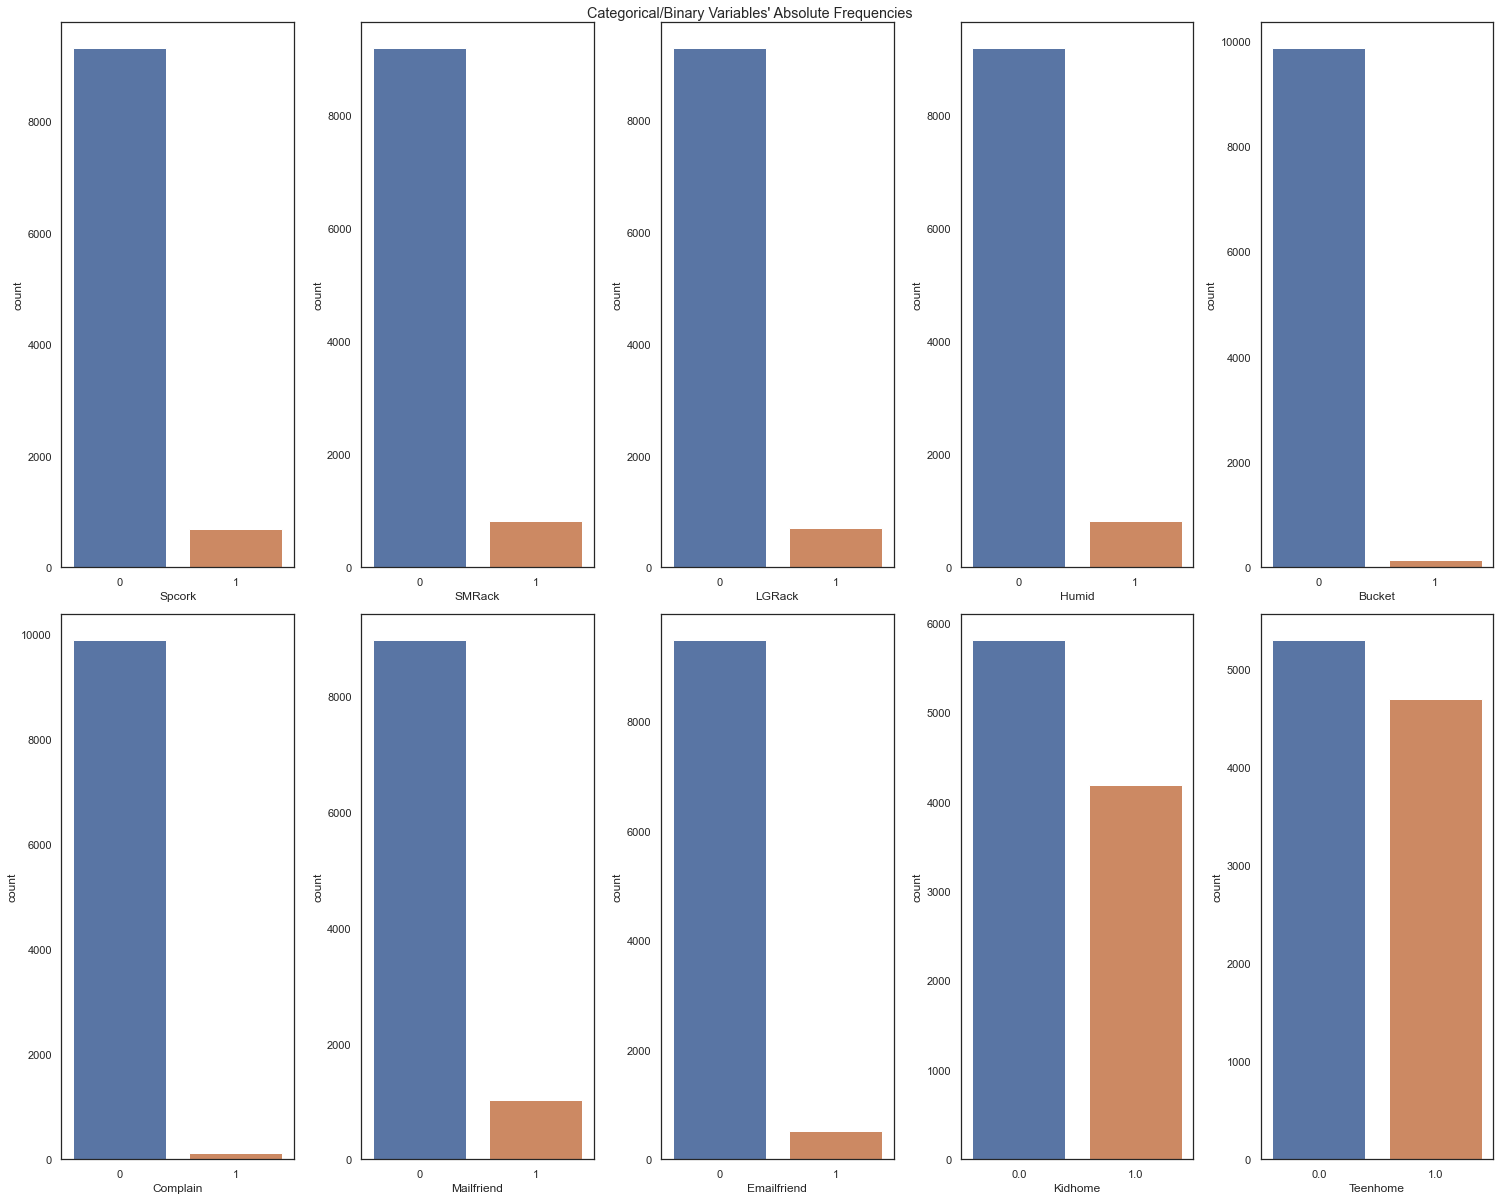

In [16]:
#visualizing the information we just checked

#setting the background
sns.set()
sns.set_style("white")

#Defining the number of barplots
fig, axes = plt.subplots(2, ceil(len(binaries) / 2), figsize=(21, 17))

#plotting for each categorical variable
for ax, feature in zip(axes.flatten(), binaries):
    sns.countplot(data[feature], ax=ax)

plt.suptitle("Categorical/Binary Variables' Absolute Frequencies")
plt.tight_layout()
plt.show()

interval columns not set, guessing: ['Dayswus', 'Age', 'Edu', 'Income', 'Kidhome', 'Teenhome', 'Freq', 'Recency', 'Monetary', 'LTV', 'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic', 'WebPurchase', 'WebVisit', 'SMRack', 'LGRack', 'Humid', 'Spcork', 'Bucket', 'Access', 'Complain', 'Mailfriend', 'Emailfriend']


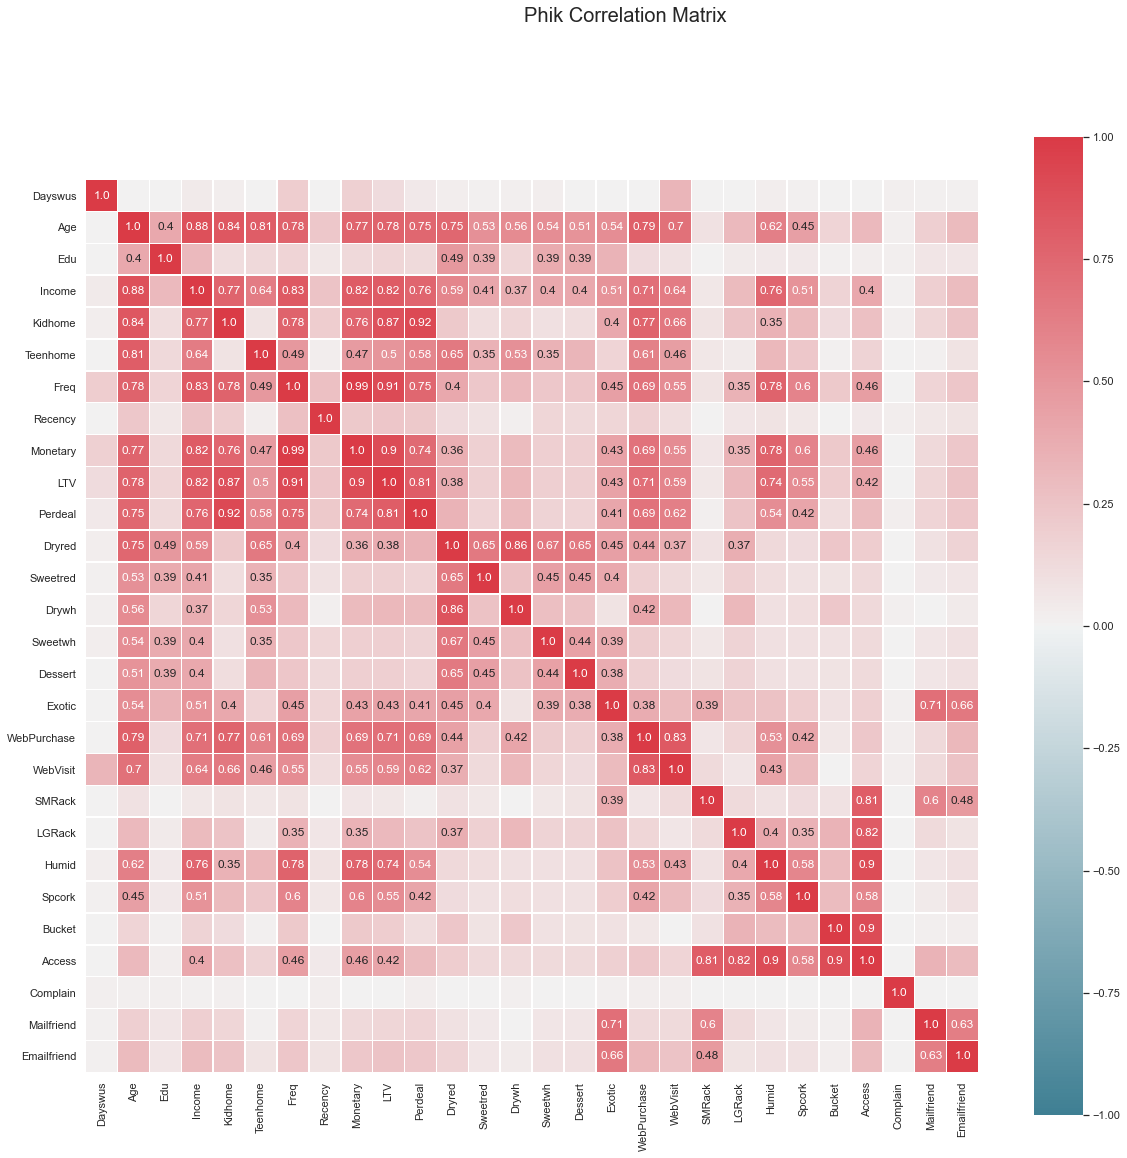

In [17]:
#Plotting a Phik correlation matrix between all our variables

fig = plt.figure(figsize=(20, 18))

#Computing the correlations
corr = np.round(data.phik_matrix(), decimals=2)

#selecting the values we want to see highlighted in the visualization
mask_annot = np.absolute(corr.values) >= 0.35
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

#plotting it
sns.heatmap(data=corr,  annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

fig.suptitle("Phik Correlation Matrix", fontsize=20)
plt.show()

#There are some interesting findings. Firstly, the variable Recency keeps showing up as a variables that might be problematic (low correlation with all variables). Furthermore, the variable that indicates by how long the person is with WWW also don't seem to influence the patterns in the other variables also suggesting it may not be a good variable to be used in clustering. Laslty, there also don't seem to exist any relation between the client having made a complain in the last months with any other variable.
#On the side of the high correlations, and not ignoring the amount of moderate to strong correlation that exist, it is specially worthy to focus on correlations that assume values that will most likelly interfer with our models. We will set this thresould at 0.85. Being this said, on the metric feature side, we have a high correlation between LTV, Freq. and Monetary (that may have to do with the way the variable LTV as constructed), between Income and Age and between Dryred and Drywh (maybe people like dry wine regardless of the type). Moreover, acess also seems correlated with Humid and Bucked (which makes sense considering with captures the number of Humid + Bucket + SMRACK + LGRACK purchased), and between Kidhome, LTV and Perdeal. All these correlations were positive.

In [18]:
#Creating a list with the metric variables which are more correlated
correlated = ["Age", "Income", "Freq", "Monetary", "LTV", "Dryred", "Drywh", "Perdeal"]

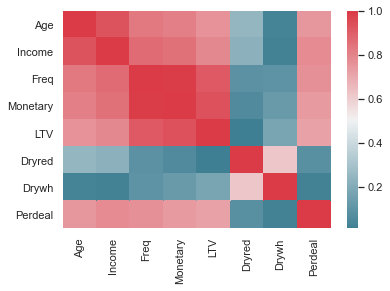

In [19]:
#By isolating the variables that are more correlated we can have a better idea of the association between their correlations (this time using the Pearson)
#Plotting a Parson correlation matrix only with the metric variables we verified were most correlated among them
sns.set()
sns.heatmap(data[correlated].corr().abs(), cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [20]:
#Computing the sum of the values of all the variables which are related with Accessories bought by the customers (Humid, Bucket, SMRack, LGRack)

(data[ "Humid" ]+ data["Bucket"] + data["SMRack"] + data["LGRack" ]).value_counts()

0    8009
1    1579
2     355
3      57
dtype: int64

In [21]:
#seeing that the sum of the previously mentioned accessories variables is equal to the value present in the Access variable

data["Access"].value_counts()

0    8009
1    1579
2     355
3      57
Name: Access, dtype: int64

In [22]:
#By isolating the variables that are more correlated we can have a better idea of the association between their correlations (this time using the Pearson)

### Data Quality Verification

In [23]:
#cheking if our dataset has any missing value
data.isnull().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Kidhome        0
Teenhome       0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
SMRack         0
LGRack         0
Humid          0
Spcork         0
Bucket         0
Access         0
Complain       0
Mailfriend     0
Emailfriend    0
dtype: int64

In [24]:
#checking if our dataset has ny duplicated rows/customers
data.loc[data.duplicated(keep=False), :]

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Kidhome, Teenhome, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit, SMRack, LGRack, Humid, Spcork, Bucket, Access, Complain, Mailfriend, Emailfriend]
Index: []

[0 rows x 28 columns]

In [25]:
#checking if the sum of these 5 variables is indeed 100, as mentioned in the metadata
(data["Dryred"]+data["Sweetred"] + data["Drywh"]+ data["Sweetwh"] + data["Dessert"]).value_counts()

100.0    7381
99.0     1431
101.0    1188
dtype: int64

In [26]:
#checking if all our customers are at least 21 years old (as is the minimum age for legally driking in the U.S.)
data[data["Age"]<21].shape[0]

434

In [27]:
#Checking if our dataset has any of the following inconsistencies:

#Dayswus can't be lower than recency  
Incoherence1 = data.get(data['Dayswus'] < data['Recency'])
data.drop(Incoherence1.index,inplace = True)

#Age can't be lower than Edu
Incoherence2 = data.get(data['Age'] < data['Edu'])
data.drop(Incoherence2.index,inplace = True)

#Monetary can't be 0 if Freq is higher than 0 and vice-versa
Incoherence3 = data.get(((data['Monetary'] == 0) & (data['Freq'] > 0)) | ((data['Freq'] == 0) & (data['Monetary'] > 0)))
data.drop(Incoherence3.index,inplace = True)

## Data Preparation:

### Select data

In [28]:
#Creating a copy of our dataframe, so we can alter it and mantaing the original dataframe's integrity
data_processed = data.copy()

#Dropping the variables that according with our analysis are not useful to our problem
data_processed.drop(["Recency","Complain", "Dayswus", "Access"], axis=1, inplace=True)

#Removing these variables also form our metric_features and binaries lists

# Recency is not correlated significantly with other variables and has other significant problems already mentioned
metric_features.remove("Recency")
#due to lack of correlation with other variables, we decided to also drop Complain and Daysws
metric_features.remove("Dayswus")
binaries.remove("Complain") 
#this variable present an aglomeration of values as 0, which might be a problem with a significant portion of the values not 0 being considered outliers. Considering this and the fact we have information about the variables that were used to construct this one
metric_features.remove("Access") 


### Clean data

In [29]:
#Computing an inverse covariance matrix to calculate the Mahalanobis distance
Inverse_Covariance = sp.linalg.inv(data_processed [metric_features].cov().values)

#Computing the average of each variable
mean_columns = data_processed [metric_features].mean().values

#Defining a function to compute the Mahalanobis distance
def mahalanobis_distances(df,mean_columns,Inverse_Covariance):
    """This function receives a dataframe, an array with the average of its variables and its inverse covariance matrix.
    It returns the distance for each row of the dataframe."""
    
    distances = []
    
    #computing the distances
    for i in range(df.shape[0]):
        distances.append(mahalanobis(df.iloc[i,:],mean_columns,Inverse_Covariance) ** 2)
    
    return(distances)

#Using the mahalanobis_distances function to compute the distances of our dataframe
m_distances = mahalanobis_distances(data_processed[metric_features],mean_columns,Inverse_Covariance)

#Using these distances to check which observations, according with a Chi-squared distribution with a alpha level of 0.035, are considered outliers.
#storing them in the outliers_mahalanobis list
outliers_mahalanobis =[]
for index, distance in enumerate(m_distances):
    if distance > chi2.ppf((1-0.035),df=len(metric_features)-1):
        outliers_mahalanobis.append(data_processed.index.values[index])
        
        
#Defining a function to compute the potential outliers, using the IQR method.
def iqr_method(column):
    """This function returns a tuple with the lower and the upper bonds for a observation in a given column to be considered a potential outlier, according to the IQR method."""
    
    #Computing both the 1st and the 3rd quartiles
    q1,q3 = np.percentile(sorted(column), [25,75])
    
    #computing the lower and the upper bonds
    lower = q1 - (2.5* (q3 - q1))
    upper = q3 + (2.5* (q3 - q1))  
    
    return lower,upper

outliers_IQR=[]

#Going through each metric variables and storing in the outliers_IQR list the index of the observations which are beyond the bonds defined.
for var in metric_features:
    lower, upper= iqr_method(data_processed [var])
    if lower == upper:
        lower=upper
    else:
        indexes_outliers=data_processed [(data_processed [var]<lower)|(data_processed [var]>upper)].index.values
        for index in indexes_outliers:
            outliers_IQR.append(index)        

In [30]:
#Defining as outliers the customers which were considered as outliers by both methods.
index_outliers=[index for index in outliers_mahalanobis if (index in outliers_IQR)]

In [31]:
#Checking how many outliers we found
print("We considered", len(index_outliers), "customers as outliers, which corresponds to", round(len(index_outliers)/data_processed.shape[0]*100,2), "% of the total number of customers.")

We considered 590 customers as outliers, which corresponds to 5.9 % of the total number of customers.


In [32]:
#Storing the outliers in a separated dataframe, so they can be added later to our analysis.
outliers = data_processed.loc[index_outliers,:].copy()

#Removing them from our data_processed dataframe.
data_processed.drop(index_outliers, axis=0, inplace=True)

### Construct data

In [33]:
#We will define a Principal Component that captures the highly correlated variables Frew, Monetary, LTV, Age and Income.

#For that, we will standardize these variables (again, not on the original dataframe, as this is only for proceding to the PCA) 
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(data_processed[["Freq", "Monetary", "LTV", "Age", "Income"]]), columns= ["Freq", "Monetary", "LTV", "Age", "Income"], index= data_processed.index)

#we also apply this transformation to the outliers
y= pd.DataFrame(scaler.transform(outliers[["Freq", "Monetary", "LTV", "Age", "Income"]]), columns= ["Freq", "Monetary", "LTV", "Age", "Income"], index= outliers.index)

#Creating the PCA instance, keeping 1 P.C..
pca = PCA(n_components=1)
pca.fit(x)
print("Variance explained:", round(pca.explained_variance_ratio_[0],2))

#Creating the P.C. which will correspond to the "Value_index" 
value = pd.DataFrame(pca.transform(x), index = data_processed.index, columns=["Value_index"])
#again, we repeat to the outliers.
value_outliers= pd.DataFrame(pca.transform(y), index = outliers.index, columns=["Value_index"])

#checking the correlation of our Value_index with the variables it represents - We can see that all values are above 91.5%.
pd.concat([value, data_processed[["Freq", "Monetary", "LTV","Age", "Income"]]], axis=1, sort= False).corr().iloc[0,1:]

Variance explained: 0.9


Freq        0.975302
Monetary    0.971833
LTV         0.933996
Age         0.915813
Income      0.936908
Name: Value_index, dtype: float64

In [34]:
#Repeating the previous step, but this time to create the "Web" variable, an index of the Webvisit and Webpurchase.

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(data_processed[["WebVisit", "WebPurchase"]]), columns= ["WebVisit", "WebPurchase"], index= data_processed.index)
y=pd.DataFrame(scaler.transform(outliers[["WebVisit", "WebPurchase"]]), columns= ["WebVisit", "WebPurchase"], index= outliers.index)


pca = PCA(n_components=1)
pca.fit(x)
print("Variance explained:", round(pca.explained_variance_ratio_[0],2))

website = pd.DataFrame(pca.transform(x), index = data_processed.index, columns=["Web"])
website_outliers=pd.DataFrame(pca.transform(y), index = outliers.index, columns=["Web"])

#In this case, qe can observe that the correlation of our new variable with the ones it represents is around 97%.
pd.concat([website, data_processed[["WebVisit", "WebPurchase"]]], axis=1, sort= False).corr().iloc[0,1:]

Variance explained: 0.94


WebVisit       0.970498
WebPurchase    0.970498
Name: Web, dtype: float64

Regarding the other correlated variables, we decided not to act upon them, some of them because it is a correlation between categorical data and numeric (that won't interfer in the model), others, like the taste for dry red wine and dry white wine, because, althouth the correlation is strong, and we could just join them in a variable called taste for dry wine, it seems more informative to keep them separated as we are talking about personal tastes that may lead to wrong business conclusions if we don't manage those properly.

In [35]:
#Joining to our data_processed the 2 variables we just created
data_processed=pd.concat([data_processed,website,value], axis=1)

#doing the same to the outliers dataframe
outliers=pd.concat([outliers,website_outliers,value_outliers], axis=1)

In [36]:
#In consequence of the previous steps, we have to remove the appropriate variables from the metric_features

metric_features.remove("WebPurchase")
metric_features.remove('WebVisit')  
metric_features.remove('Monetary')
metric_features.remove('LTV')
metric_features.remove('Income') 
metric_features.remove('Freq') 
metric_features.remove('Age')
metric_features.append("Value_index")
metric_features.append("Web")

In [37]:
#In consequence of the previous steps, we have to remove the appropriate variables from the data_processed and outliers dataframes

data_processed.drop(["WebPurchase","WebVisit",'Monetary','LTV','Income', "Freq", 'Age'], axis=1, inplace=True)
outliers.drop(["WebPurchase","WebVisit",'Monetary','LTV','Income', "Freq", 'Age'], axis=1, inplace=True)

In [38]:
#Lastly, we will retify the problem encountered earlier, making the sum of Dryred, Sweetred, Drywh, Sweetwh and Dessert equal to 100.
#Doing it both to the data_processed and the ouliers dataframes.

total = (data_processed["Dryred"] +data_processed["Sweetred"] +data_processed["Drywh"]+ data_processed["Sweetwh"] + data_processed["Dessert"])
data_processed["Dryred"]=data_processed["Dryred"]/total*100
data_processed["Sweetred"]=data_processed["Sweetred"]/total *100
data_processed["Drywh"]=data_processed["Drywh"]/total*100
data_processed["Sweetwh"]=data_processed["Sweetwh"]/total *100
data_processed["Dessert"]= data_processed["Dessert"]/total *100


total_outliers = (outliers["Dryred"] +outliers["Sweetred"] +outliers["Drywh"]+ outliers["Sweetwh"] + outliers["Dessert"])
outliers["Dryred"]=outliers["Dryred"]/total_outliers*100
outliers["Sweetred"]=outliers["Sweetred"]/total_outliers *100
outliers["Drywh"]=outliers["Drywh"]/total_outliers*100
outliers["Sweetwh"]=outliers["Sweetwh"]/total_outliers *100
outliers["Dessert"]= outliers["Dessert"]/total_outliers *100

Looking now again to our data, after the cleaning and transformation process:

interval columns not set, guessing: ['Edu', 'Kidhome', 'Teenhome', 'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic', 'SMRack', 'LGRack', 'Humid', 'Spcork', 'Bucket', 'Mailfriend', 'Emailfriend', 'Web', 'Value_index']


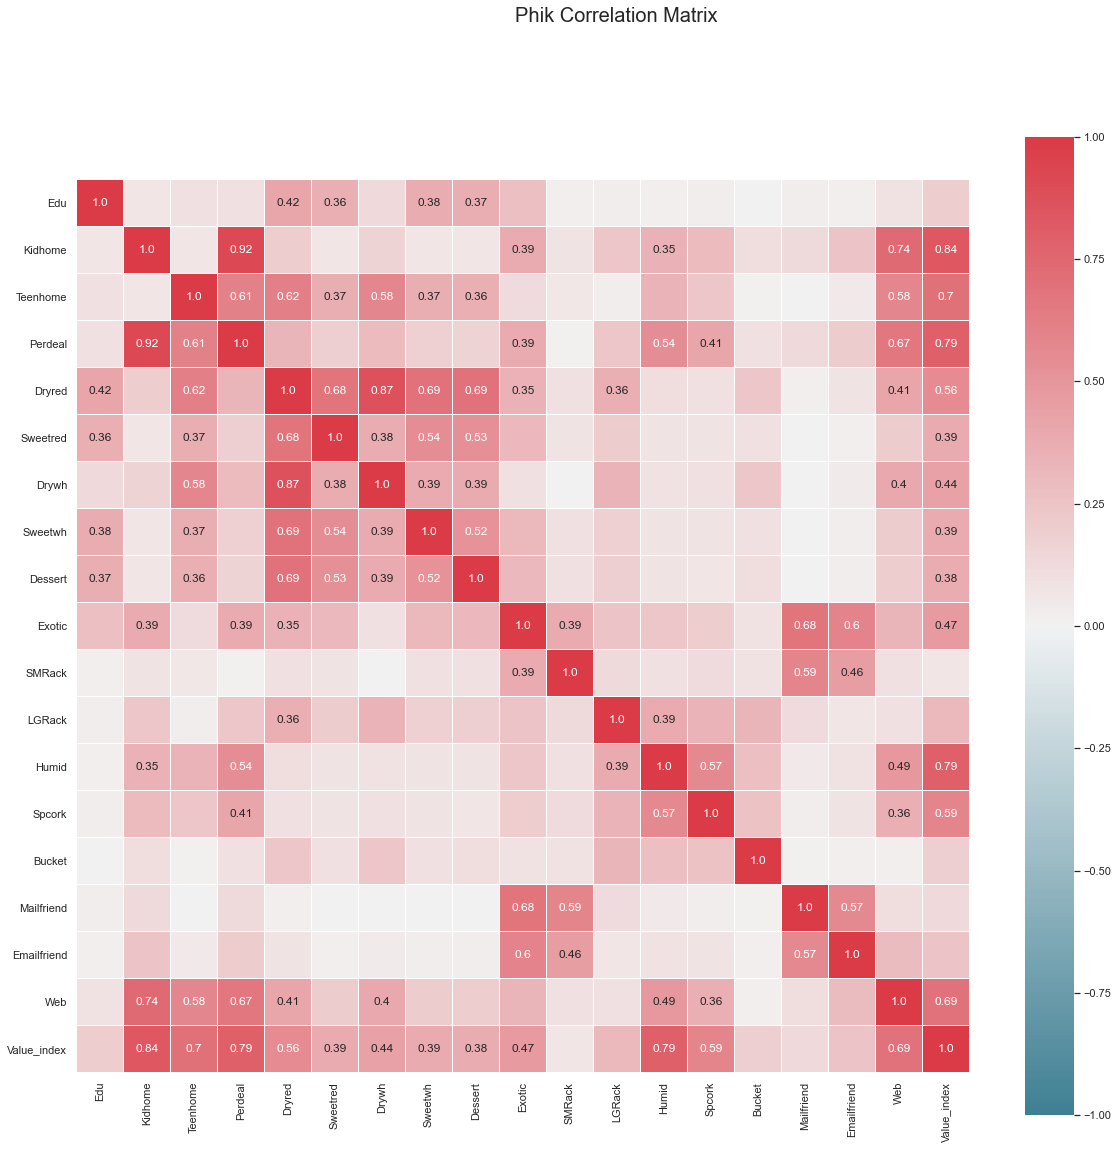

In [39]:
#Doing, once more, a Phik correlation matrix, to check that the previously encountered problems were resolved.

fig = plt.figure(figsize=(20, 18))

corr = np.round(data_processed.phik_matrix(), decimals=2)
mask_annot = np.absolute(corr.values) >= 0.35
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr,  annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

fig.suptitle("Phik Correlation Matrix", fontsize=20)
plt.show()

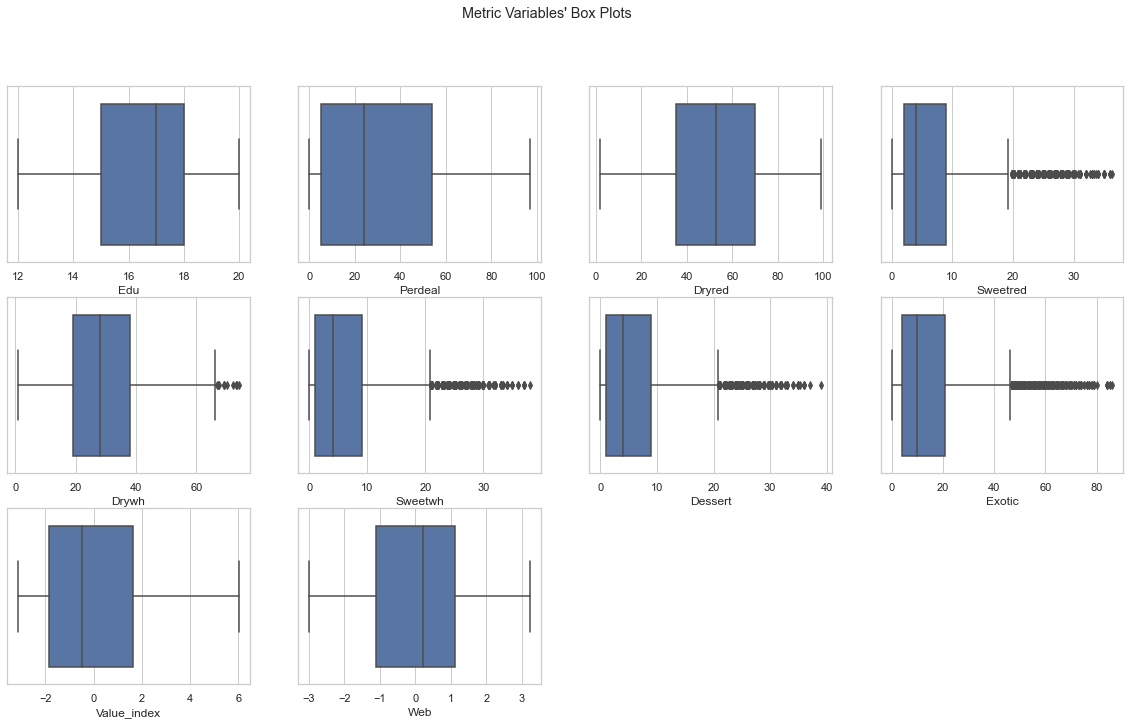

In [40]:
#Plotting, once more, the boxplots of our mteric features, to check if the distribution of our variables "improved" with the changes made.

sns.set()
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, ceil(len(metric_features)/3), figsize=(20, 11))

for ax, features in zip(axes.flatten(), metric_features):
    sns.boxplot(x=data_processed[features], ax=ax)

fig.delaxes(axes[2,2])
fig.delaxes(axes[2,3])
plt.suptitle("Metric Variables' Box Plots")
plt.show()

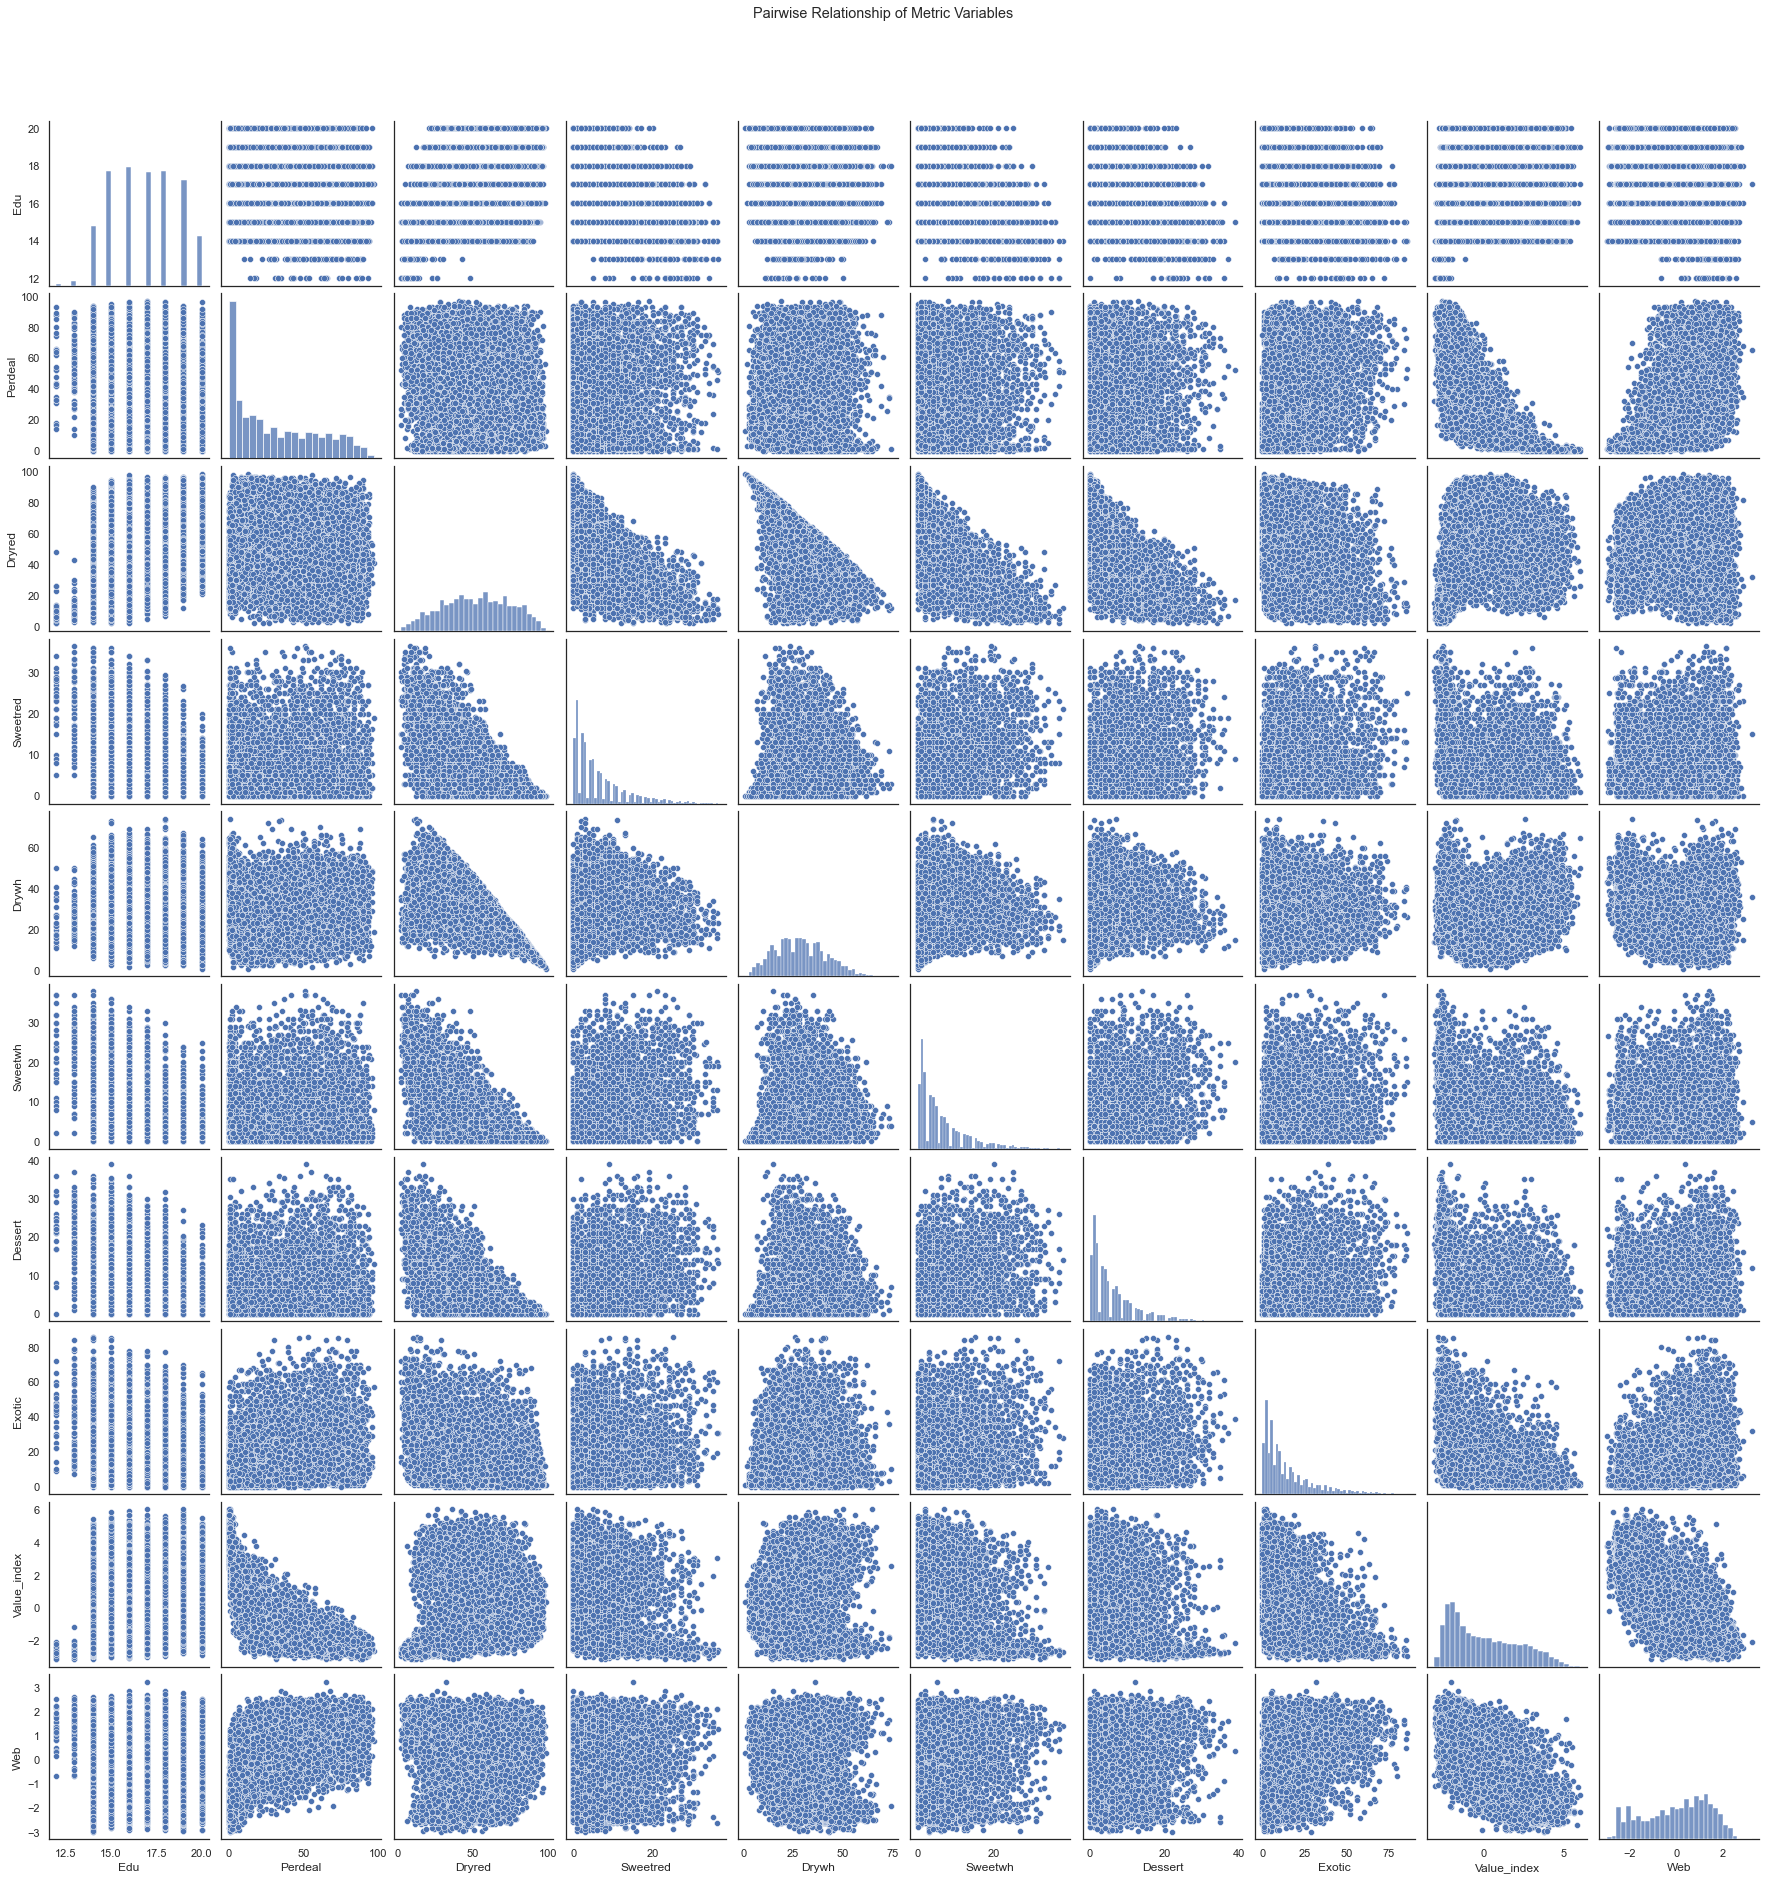

In [41]:
#Analysing, once more, the pariplot for our metric features, to see if after the changes made, we see an improvement (namely, in the ouliers previously spotted)

sns.set()
sns.set_style("white")

sns.pairplot(data=data_processed[metric_features], diag_kind="hist")

plt.suptitle("Pairwise Relationship of Metric Variables", y=1.05)
plt.show()

### Integrate data &  Format data

Not applicable

## Modeling:

### Select modeling technique

In [42]:
#Standardizing all our metric features, so we can "fit" this data to our model(s)
#Alhtough we have PCA's we will also scale those, as we have constructed a meaningfull variable out of them, and we want them to be behave exactly the same and impact the model the same as the others, and if not standarized again, they would not have 1 of standard deviation as the remaning
scaler = StandardScaler()
data_processed[metric_features] = pd.DataFrame(scaler.fit_transform(data_processed[metric_features]), columns= metric_features , index=data_processed.index)

#Doing the same to the ouliers, so further ahead is in the same scale as data_processed, even if this dataframe will not be considered to the build the model.
outliers[metric_features] = pd.DataFrame(scaler.transform(outliers[metric_features]), columns= metric_features , index=outliers.index)

### Generate test design

Not applicable.

### Build the model

In [43]:
#Selecting the variables we consider to be appropriate to be included in the "Wine Taste" clustering perspective.
wine_taste= ['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']

Using the inertia plot it seems that 3 is a good elbow point (2 also seem valid, but we will go with 3, as latter on we can always use a hierarchical cluster to reduce the number of clusters if appropriate). Furthermore, and althouth the silhouete score is higher for the 2 clusters case, we would have a very good cluster and a almost all below average (as shown in the graph of the silhoute)

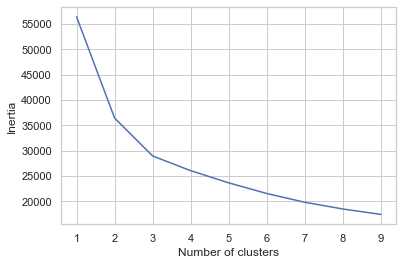

In [44]:
#Computing the inertia for the clustering solutions of the Wime Taste perspective if the number of clusters from 1 to 9, in order to see which is the ideal number of clusters to select.

inertias=[]

range_clusters = range(1, 10)

for nr_clusters in range_clusters:
    kmeans= KMeans(n_clusters=(nr_clusters), init="k-means++", n_init=10, random_state=42)
    labels= kmeans.fit_predict(data_processed[wine_taste])
    inertias.append(kmeans.inertia_)

sns.set()
sns.set_style("whitegrid")   
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")

plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3345992650467174
For n_clusters = 3, the average silhouette_score is : 0.2893672682202917


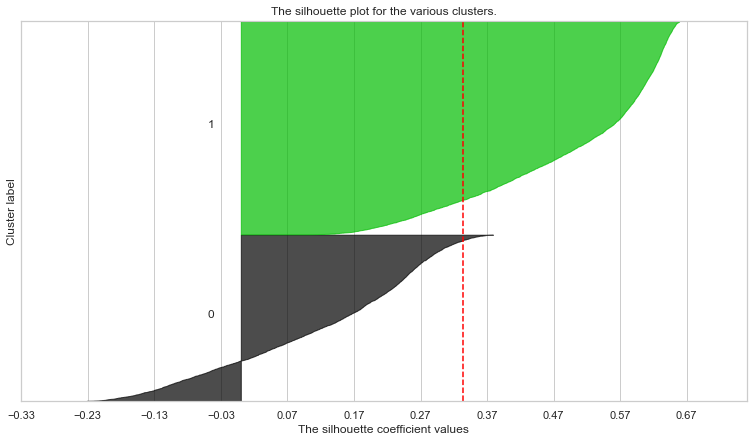

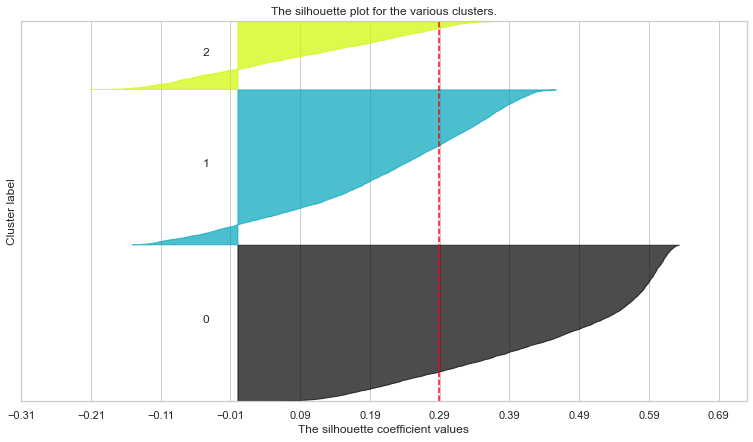

In [45]:
# Adapted from: https://github.com/DavidSilva98/DMDSAA/blob/master/notebooks_solutions/lab09_kmeans_clustering.ipynb

#Plotting the Silhouette graphs and calculating the Silhouette score for the clsutering solutions with 2 and 3 clusters.

#creating an auxiliary list
avg_silhouette = []

#defining the number of clusters to analyse
range_clusters= [2,3]

#Repeating this process for the solution with both 2 and 3 clusters.
for nclus in range_clusters:
    
    fig = plt.figure(figsize=(13, 7))
    
    #Applying a K-Means and storing the labels computed
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data_processed[wine_taste])

    #Computing the average Silhouette Score according to the labels previously achieved and storing it
    silhouette_avg = silhouette_score(data_processed[wine_taste], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")
    
    #computing the Sample Silhouette Scores, so we can proceed to plot them.
    sample_silhouette_values = silhouette_samples(data_processed[wine_taste], cluster_labels)
    
    
    #Plotting the Sample silhouette Graph for each clustering solution.
    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
       
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(data_processed[wine_taste]) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

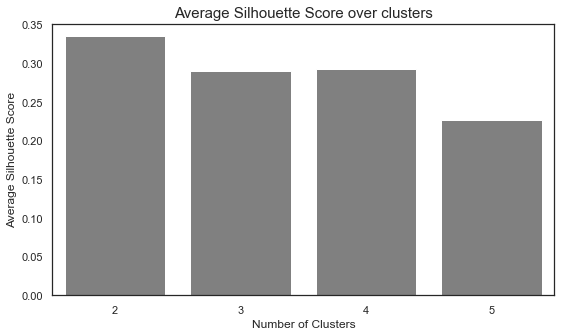

In [46]:
#Plotting the average silhouette score for clustering solutions from 2 to 5 clusters
avg_silhouette=[]
nr_range=range(2,6)

#Applying a K-Means and computing the associated average silhouette score
for nclus in nr_range:
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data_processed[wine_taste])
    silhouette_avg = silhouette_score(data_processed[wine_taste], cluster_labels)
    avg_silhouette.append(silhouette_avg)

fig = plt.figure(figsize=(9,5))
sns.set()
sns.set_style("white")
sns.barplot(y=avg_silhouette, x=[i for i in nr_range], color="grey")
plt.title("Average Silhouette Score over clusters", size=15)
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

In [47]:
#Now that we have chosen the appropriate number of clusters, we will apply a K-Means and store the labels produced in our data_processed dataframe.

kmeans= KMeans(n_clusters=3, init="k-means++", n_init=10, random_state=42)
data_processed["Taste_Group"]= kmeans.fit_predict(data_processed[wine_taste])

We will just take a overall look at our clusters centroid. Just to verify some separability. Note that according to pure Crisp-DM we would only do this type of check in model assesment, but as this is a very specific case where the final model is build based on 2 smaller models, it is important to assure the middle steps are being properly done, so this can still be considering as part of modelling and not as assesment. 

In [48]:
#checking the "typical" customers' characteristics of each cluster in the Wine Taste perspective
data_processed[wine_taste + ["Taste_Group"]].groupby("Taste_Group").mean()

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic
Taste_Group                                                            
0            0.987060 -0.603023 -0.816965 -0.602895 -0.610348 -0.228019
1           -0.445984 -0.017178  0.765808  0.024052  0.034239 -0.175321
2           -1.253792  1.420619  0.141170  1.327138  1.321191  0.918750

In [49]:
#defining the metric features to use for the Engagement perspective as the ones not used in the Taste perspective.
engagement =[]
for var in metric_features:
    if var not in wine_taste:
        engagement.append(var)

In this perspective, the correct number of clusters seems clearly to be 2.

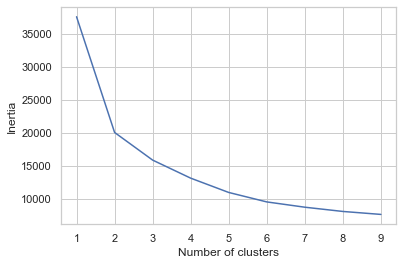

In [50]:
#As in the previous perspective, plotting a inertia plot to assess the ideal number of clusters.

inertias=[]

for nr_clusters in range(1,10):
    kmeans= KMeans(n_clusters=(nr_clusters), init="k-means++", n_init=10, random_state=42)
    labels= kmeans.fit_predict(data_processed[engagement])
    inertias.append(kmeans.inertia_)
        
sns.set()
sns.set_style("whitegrid")
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")

plt.show()

For n_clusters = 2, the average silhouette_score is : 0.392825349242592
For n_clusters = 3, the average silhouette_score is : 0.3199134039449186


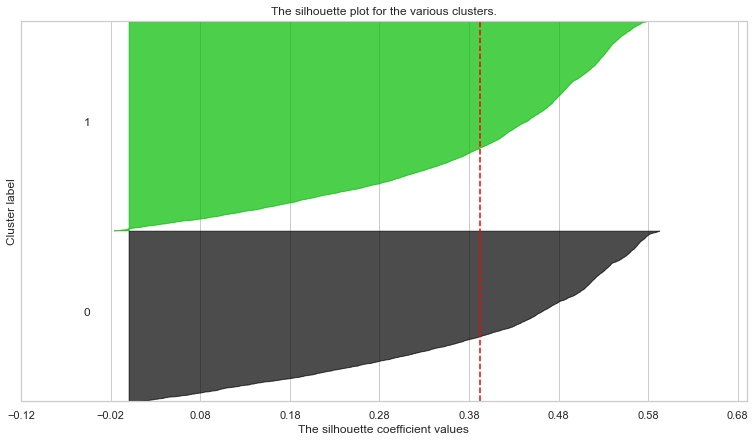

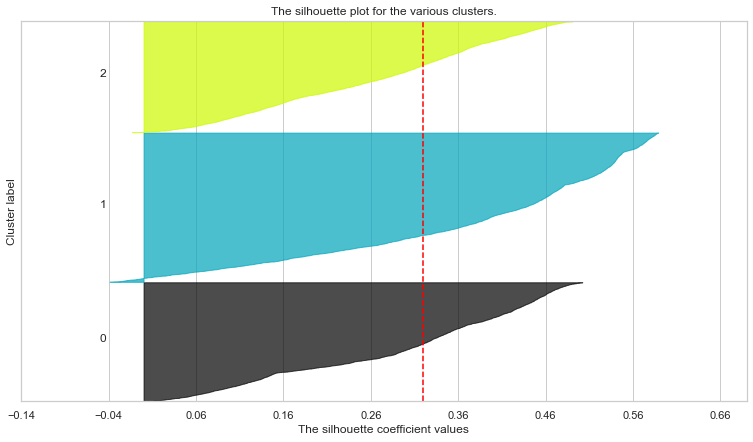

In [51]:
# Adapted from: https://github.com/DavidSilva98/DMDSAA/blob/master/notebooks_solutions/lab09_kmeans_clustering.ipynb

#Following the same steps as before, but this time for the Engagement perspective.

avg_silhouette = []
range_clusters=[2,3]

for nclus in range_clusters:
    if nclus == 1:
        continue
     
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data_processed[engagement])

    silhouette_avg = silhouette_score(data_processed[engagement], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data_processed[engagement], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
       
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(data_processed[engagement]) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

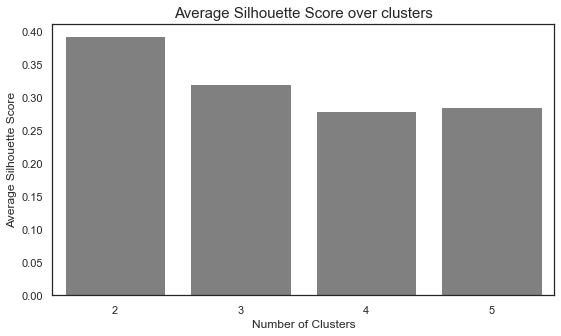

In [52]:
#Once more, plotting the average silhouette scores for the different clustering solutions obtained.


fig = plt.figure(figsize=(9,5))

avg_silhouette=[]
nr_range=range(2,6)

for nclus in nr_range:
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data_processed[engagement])
    silhouette_avg = silhouette_score(data_processed[engagement], cluster_labels)
    avg_silhouette.append(silhouette_avg)

sns.set()
sns.set_style("white")
sns.barplot(y=avg_silhouette, x=[i for i in nr_range], color="grey")
plt.title("Average Silhouette Score over clusters", size=15)
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.show()


In [53]:
#Using the ideal number of clusters of 2 and producing a clustering solution. Storing the correspondent labels in our data_processed dataframe.

kmeans= KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
data_processed["Engagement_Group"]= kmeans.fit_predict(data_processed[engagement])

Again, we will just take a overall look at our clusters centroid. Just to verify some separability. Note that according to pure Crisp-DM we would only do this type of check in model assesment, but as this is a very specific case where the final model is build based on 2 smaller models, it is important to assure the middle steps are being properly done, so this can still be considering as part of modelling and not as assesment. 

In [54]:
#Checking the characteristics of the "typical" customer in each cluster of this perspective
data_processed[engagement + ["Engagement_Group"]].groupby("Engagement_Group").mean()

Edu   Perdeal  Value_index       Web
Engagement_Group                                           
0                 0.103171 -0.866850     0.909001 -0.832155
1                -0.084467  0.709698    -0.744207  0.681293

We will now merge the clusters and use hierarchical clustering to see if it is worthy to join some clusters (that are fairly similar) so we have more generic marketing campaigns, while still being targeted and focus on the representative segments of our customers. In this case, we decided to merge 4 clusters in 2, which means our final solution will have 4 clusters.

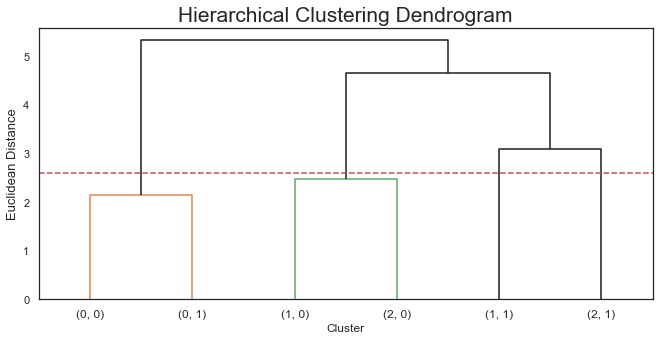

In [55]:
# Adapted from: https://github.com/DavidSilva98/DMDSAA/blob/master/notebooks_solutions/lab12_cluster_analysis.ipynb

#Defining the centroids of the clusters formed by merging both perspectives.
df_centroids = data_processed.groupby([ "Taste_Group", "Engagement_Group"])[metric_features].mean()

#Creating the Hierarchical Cluster intance
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

#Defining a label to each centroid.
hclust_labels = hclust.fit_predict(df_centroids)



#Computing the number of observations being merged in each node.
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


#Going through the observations
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        #checking if we are merging observations
        if child_idx < n_samples:
            current_count += 1
        #checking if we are merging a previously formed cluster
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    
#Defining a matrix with the observations/clusters merged and the correspondent distance
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plotting the dendogram
sns.set()
sns.set_style("white")
fig = plt.figure(figsize=(11,5))
y_threshold = 2.6
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Cluster')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [56]:
#Merging the clusters that according with the Hierarchical Clustering make sense to be merged.
#In this case, joining cluster (0,0) with (0,1) and (1,0) with (2,0).
#this way, we go from 6 to 4 clusters, so we need to redefine our cluster labels.

for customer in data_processed.index:
    if data_processed.loc[customer,"Taste_Group"] == 0:
        data_processed.loc[customer,"Final"]= 0
    elif (data_processed.loc[customer,"Engagement_Group"] == 0) and ((data_processed.loc[customer,"Taste_Group"] == 1) or (data_processed.loc[customer,"Taste_Group"] == 2)):
        data_processed.loc[customer,"Final"]=1
    elif (data_processed.loc[customer,"Engagement_Group"] == 1) and (data_processed.loc[customer,"Taste_Group"] == 1):
        data_processed.loc[customer,"Final"]=2
    else:
        data_processed.loc[customer,"Final"]=3

We can now, end our process of modelling, by completing the model adding the outliers back. The change of neighboors to 1 is justified by how we just want to join a point to the closest centroid.

In [57]:
#Computing the centroid of each of our 4 clusters.
centroids = data_processed.groupby("Final")[metric_features].mean()

#Creating data_joined, a dataframe with our data_processed and the outliers.
data_joined = pd.concat([outliers, data_processed.drop(["Taste_Group","Engagement_Group"],axis=1)])

#Creating the KNN instance
model = KNeighborsClassifier(n_neighbors=1)

#Fiting it the centroids
model.fit(centroids, centroids.index)

#storing the predicted label for each outlier, according with its nearest centroid.
data_joined.loc[outliers.index, "Final"]= model.predict(outliers[metric_features])

#converting our labels to integers, just for visualization purposes.
data_joined["Final"]=data_joined["Final"].astype(int)

### Assess the model

In order to acess the quality of our model, and being based on a subjective criteria, we will try to use some visualization tools. We will try to see how the "typical customer" of each cluster is differentiated from the other "typical customers", by looking at the centroids values across metric and binary features. We will also look to the number of customers per cluster, to a visualization in the 2D space of our customers separated by cluster and to the most important features while creating this separation.

In [58]:
#checking the "typical" customers of our final cluster solution.
data_joined.groupby("Final")[metric_features].mean()

Edu   Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert  \
Final                                                                         
0      0.380113  0.017225  0.987296 -0.602988 -0.817341 -0.602975 -0.610382   
1     -0.149530 -0.927244 -0.591026  0.317912  0.568299  0.304782  0.309029   
2     -0.049645  0.833735 -0.421201 -0.079909  0.812100 -0.035186 -0.020645   
3     -1.046643  0.804262 -1.468899  1.664319 -0.000597  1.702624  1.729354   

         Exotic  Value_index       Web  
Final                                   
0     -0.227341    -0.014822  0.205787  
1     -0.366817     1.053696 -1.095188  
2      0.233322    -0.843847  0.743018  
3      1.537080    -1.075268  0.678903

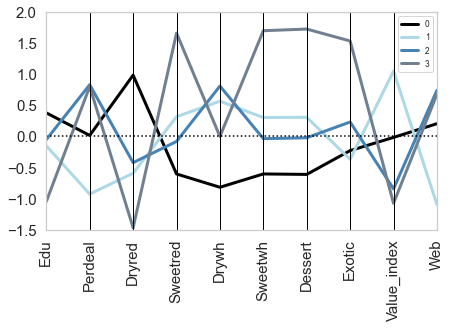

In [59]:
#plotting the previous results, so it's easier to analyse

plt.figure(figsize=(7,4))

sns.set_style("whitegrid")

centroids=data_joined.loc[:,metric_features + ["Final"]].groupby(by="Final", as_index=False).mean()
centroids["Final"]=[0,1,2,3]

pd.plotting.parallel_coordinates(centroids, "Final", color=["black","lightBlue", "SteelBlue", "SlateGrey"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.xticks(rotation=90)
plt.tick_params(labelsize=15)
plt.ylim(-1.5,2)
plt.legend(loc="upper right", fontsize="x-small")
plt.show()

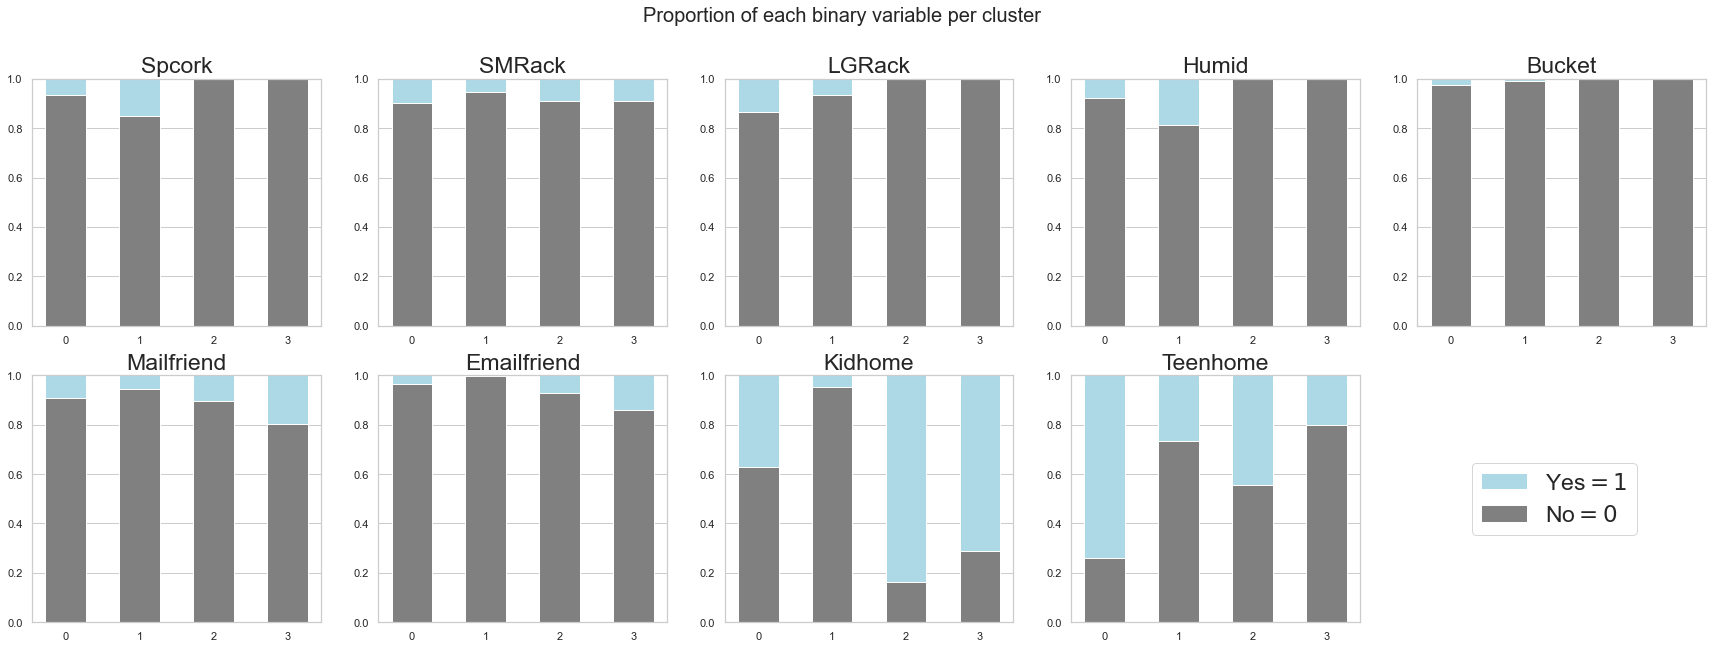

In [60]:
#defining the number of plots
fig, axes = plt.subplots(2, ceil(5), figsize=(30, 10))

i=0

#plotting each graph
for ax, features in zip(axes.flatten(), binaries):
    
    #Computing the absolute values for the combinations of the variables and clusters.
    cont_tab = pd.crosstab(data_joined["Final"], data_joined[features], margins = True)
    categories = cont_tab.index[:-1]
    
    #auxiliary data for the Proportion plot: the Proportions by cluster
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
    np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
    
    #plotting the bars
    p1 = ax.bar(categories, obs_pct[0], 0.55, color="grey", tick_label=[0,1,2,3])
    p2 = ax.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="lightblue")
    if i==8:
        ax.legend((p2[0], p1[0]), ("Yes"+'$=1$', "No"+'$=0$'), loc='center right', bbox_to_anchor=(2, 0.5),  prop={'size': 23})
    ax.set_ylim(0, 1)
    ax.set_title(features, fontdict={'fontsize': 23})
    i+=1
fig.delaxes(axes[1,4])

plt.suptitle("Proportion of each binary variable per cluster", fontsize=20)
plt.show()

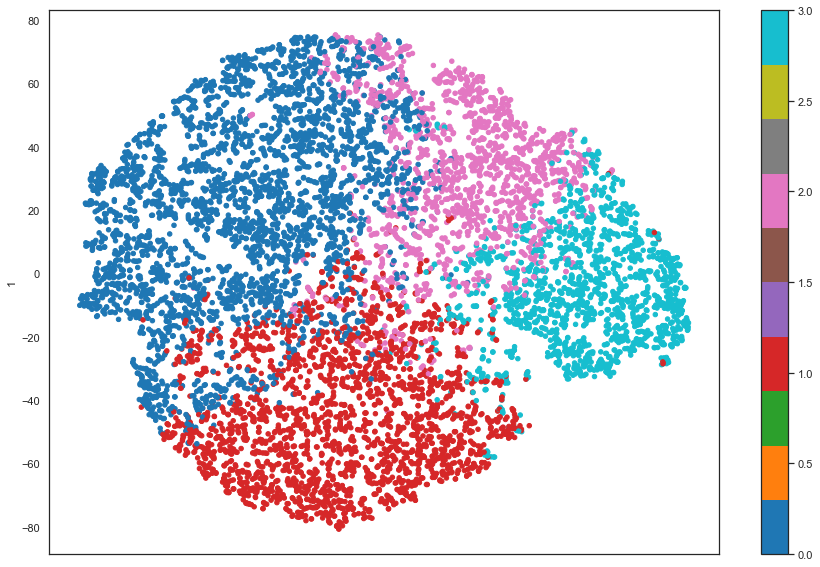

In [61]:
#Doing a t-SNE visualization, so we can see the separation of our clusters in a 2-D space.

two_dim = TSNE(random_state=42).fit_transform(data_joined.loc[:, metric_features])
sns.set_style("white")
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=data_joined.loc[:, "Final"], colormap='tab10', figsize=(15,10))
plt.show()

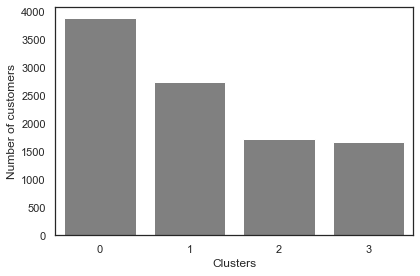

In [62]:
#Seeing the distribution of customers per each cluster formed.

sns.set()
sns.set_style("white")
countplot=sns.countplot(x="Final", data=data_joined, color="grey")
countplot.set(xlabel="Clusters", ylabel = "Number of customers")
plt.tight_layout()
plt.show()
del centroids, countplot

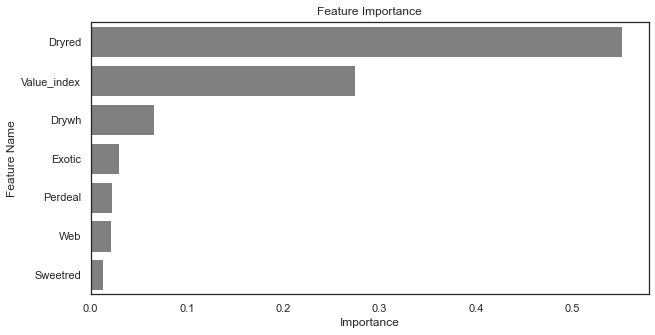

In [63]:
#Using a Decision Tree Classifier to see which variables are more important to distinguish between the customers from each cluster formed.
sns.set()
sns.set_style("white")
plt.figure(figsize=(10,5))

#Creating the DTC instance and fiting it the data_joined dataframe
dt=DecisionTreeClassifier(random_state=42)
dt.fit(data_joined.drop(["Final"], axis=1), data_joined["Final"])

#Storing the feature importance in a dataframe
feature_importance=pd.DataFrame(dt.feature_importances_, columns=["Importance"])

#Renaming the columns
feature_importance["Feature Name"]=data_joined.drop("Final", axis=1).columns
#sorting by descending order
feature_importance.sort_values(by="Importance", ascending = False, inplace = True)

#plotting it
plt.title("Feature Importance", y=1.005)
sns.barplot(y='Feature Name', x='Importance', data=feature_importance.iloc[:7,:], color = "grey")
plt.show()

R-squared for the final clustering solution.

In [64]:
#Defining a function to get the Sum of Squares for a Dataframe, and other to obtain its R-squared

def get_ss(df):
    """This funciton receives a dataframe and returns its toal sum of squares."""
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

def get_r2(df,column):
    """This fucntion receives a dataframe and a column name and returns the R-squared according to it."""
    sst = get_ss(df.drop(columns=column))  
    ssw_labels = df[df.drop(columns=column).columns.to_list() + [column]].groupby(by=column).apply(get_ss)
    ssb = sst - np.sum(ssw_labels)  
    r2 = ssb / sst
    return r2

In [65]:
#creating a auxiliar dataframe with only the metric_features and the Final label
df_joined=data_processed[metric_features + ["Final"]]

#computing the average silhouette score.
#Then, using the get_r2 function, calculate the R-squared of our final clustering solution.
ss= silhouette_score(data_joined[metric_features], data_joined["Final"])

print("The R-squared of our final clustering solution is", round(get_r2(df_joined,'Final'), 2), ", while its average Silhouette Score is", round(ss,2))

del df_joined

The R-squared of our final clustering solution is 0.45 , while its average Silhouette Score is 0.19
